In [164]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# Automatically set Data Frames to 2 decimal places
pd.options.display.precision = 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [54]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine) 

In [10]:
# Using the inspector tool, view all columns from Measurement Table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [108]:
# Using the inspector tool, view all columns from Station Table
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [122]:
session.query(Station.station).all()

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

# Exploratory Climate Analysis

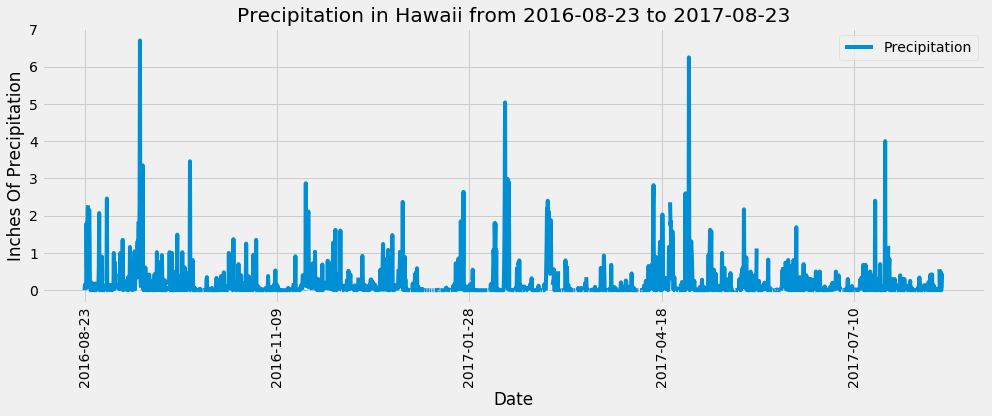

In [193]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)


# print("Date 1 year ago from last data point in the database: ", year_ago)

# Perform a query to retrieve the data and precipitation scores
twelve_months = session.query(Measurement.date, Measurement.prcp).\
     filter(Measurement.date >= dt.date(2017, 8, 23) - (dt.timedelta(days=365))).\
     order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(twelve_months)
df = df.rename(columns = {"date" : "Date", "prcp" : "Precipitation"})

# Sort the dataframe by date
df = df.set_index("Date").sort_index(ascending = True)
df 

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(14,6))
plt.ylabel("Inches Of Precipitation")
plt.title(f"Precipitation in Hawaii from {year_ago} to 2017-08-23")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [165]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [62]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(distinct(Station.station))).all()[0][0]
# station_count

print(f"The number of stations available in the dataset is {station_count}")

The number of stations available in the dataset is 9


In [166]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Station.station, Station.name, func.count(Measurement.station)).\
filter(Measurement.station == Station.station).\
group_by(Station.name).all()

active_df = pd.DataFrame(active_stations, columns = {"Station", "Name", "Count"})
active_df = active_df.rename(columns = {"Station" : "Count", "Name" : "Station", "Count" : "Name"})
active_df = active_df.set_index("Station")
active_df = active_df.sort_values("Count", ascending = False)
active_df

,Name,Count
Station,,
USC00519281,"WAIHEE 837.5, HI US",2772
USC00519397,"WAIKIKI 717.2, HI US",2724
USC00513117,"KANEOHE 838.1, HI US",2709
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
USC00517948,"PEARL CITY, HI US",1372
USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [167]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stationtemp = session.query(Station.station, Station.name, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Station.station == 'USC00519281').all()

temp_df = pd.DataFrame(stationtemp, columns = {"Station", "Name", "Max", "Min", "Average"})
temp_df = temp_df.rename(columns = {"Min" : "Station", "Average" : "Name", "Name" : "Min", "Station" : "Average"})
temp_df

,Station,Name,Min,Max,Average
0,USC00519281,"WAIHEE 837.5, HI US",87.0,53.0,73.1


In [197]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
waihee_latest_date = session.query(Measurement.date).\
    filter(Station.station == 'USC00519281').\
        order_by(Measurement.date.desc()).first()
waihee_earliest_date = session.query(Measurement.date).\
    filter(Station.station == 'USC00519281').\
        order_by(Measurement.date).first()

# waihee_latest_date
# waihee_earliest_date

waihee_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

waihee_twelve_months = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= dt.date(2017, 8, 23) - (dt.timedelta(days=365))).\
     order_by(Measurement.date).all()

waihee_df = pd.DataFrame(waihee_twelve_months)
waihee_df = waihee_df.rename(columns = {"date" : "Date", "tobs" : "Observed Temperatures"})
waihee_df


,Date,Observed Temperatures
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


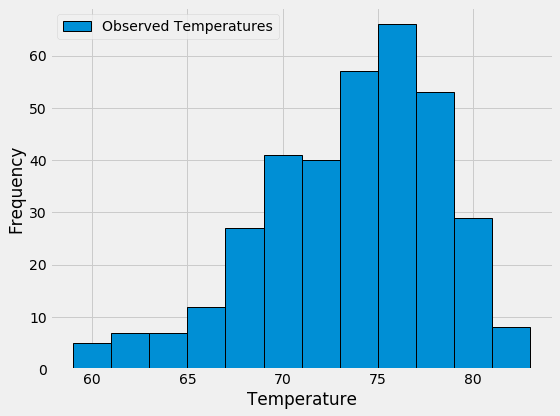

In [198]:
waihee_df.plot(figsize = (8,6), kind='hist', bins=12, label=True, edgecolor='black', linewidth=1)
plt.xlabel("Temperature")
plt.tight_layout()
plt.show();

## Bonus Challenge Assignment

In [84]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [85]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


In [83]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
